# **Dataset 1: University of Jordan**

In this notebook we'll go through the entire process of exploratory data analysis, synthetic data generation (SDG) and evaluation for Dataset 1: Kalboard360 LMS.

The evaluation approach that is used was suggested by  Liu et al. [1]. The goal is to provide a comprehensive evaluation for synthetic tabular data in learning analytics that encompasses utility, resemblance and privacy metrics. The dataset used in this notebook contains 480 student records from the University of Jordan and the data was collected from a LMS called Kalboard 360. For more details on the dataset see the papers [2, 3].

Dataset source: https://www.kaggle.com/datasets/aljarah/xAPI-Edu-Data/data

<br>


**References:**

[1] Qinyi Liu, Mohammad Khalil, Ronas Shakya, and Jelena Jovanovic. 2024.
Scaling While Privacy Preserving: A Comprehensive Synthetic Tabular
Data Generation and Evaluation in Learning Analytics. In The 14th Learning
Analytics and Knowledge Conference (LAK ’24), March 18–22, 2024, Kyoto,
Japan. ACM, New York, NY, USA, 12 pages. https://doi.org/10.1145/3636555.
3636921

[2] Amrieh, E. A., Hamtini, T., & Aljarah, I. (2016). Mining Educational Data to Predict Student’s academic Performance using Ensemble Methods. International Journal of Database Theory and Application, 9(8), 119-136.

[3] Amrieh, E. A., Hamtini, T., & Aljarah, I. (2015, November). Preprocessing and analyzing educational data set using X-API for improving student's performance. In Applied Electrical Engineering and Computing Technologies (AEECT), 2015 IEEE Jordan Conference on (pp. 1-5). IEEE


#### **Import Packages**
First, import the necessary packages.

In [1]:
import multiprocessing
import subprocess
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import sys

sys.path.append(os.path.abspath("../src"))

from generation.data_synthesizer import ds_generate_data
from generation.synthetic_data_vault import sdv_generate_data
from evaluation.utility import run_utility_eval
from evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from evaluation.privacy import dcr, nndr, mia
from sklearn.preprocessing import LabelEncoder

#### **Exploratory Data Analysis**

Let's take a look at the dataset.

In [2]:
data_path = "../data/original_data/1_university_of_jordan/1_university_of_jordan.csv"
original_data = pd.read_csv(data_path)
original_data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [3]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   gender                    480 non-null    object
 1   NationalITy               480 non-null    object
 2   PlaceofBirth              480 non-null    object
 3   StageID                   480 non-null    object
 4   GradeID                   480 non-null    object
 5   SectionID                 480 non-null    object
 6   Topic                     480 non-null    object
 7   Semester                  480 non-null    object
 8   Relation                  480 non-null    object
 9   raisedhands               480 non-null    int64 
 10  VisITedResources          480 non-null    int64 
 11  AnnouncementsView         480 non-null    int64 
 12  Discussion                480 non-null    int64 
 13  ParentAnsweringSurvey     480 non-null    object
 14  ParentschoolSatisfaction  

In [4]:
original_data.isnull().sum()

gender                      0
NationalITy                 0
PlaceofBirth                0
StageID                     0
GradeID                     0
SectionID                   0
Topic                       0
Semester                    0
Relation                    0
raisedhands                 0
VisITedResources            0
AnnouncementsView           0
Discussion                  0
ParentAnsweringSurvey       0
ParentschoolSatisfaction    0
StudentAbsenceDays          0
Class                       0
dtype: int64

Great, no null values!

In [5]:
original_data.nunique()

gender                       2
NationalITy                 14
PlaceofBirth                14
StageID                      3
GradeID                     10
SectionID                    3
Topic                       12
Semester                     2
Relation                     2
raisedhands                 82
VisITedResources            89
AnnouncementsView           88
Discussion                  90
ParentAnsweringSurvey        2
ParentschoolSatisfaction     2
StudentAbsenceDays           2
Class                        3
dtype: int64

Save categorical columns for encoding

In [6]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

gender ['M' 'F']
NationalITy ['KW' 'lebanon' 'Egypt' 'SaudiArabia' 'USA' 'Jordan' 'venzuela' 'Iran'
 'Tunis' 'Morocco' 'Syria' 'Palestine' 'Iraq' 'Lybia']
PlaceofBirth ['KuwaIT' 'lebanon' 'Egypt' 'SaudiArabia' 'USA' 'Jordan' 'venzuela' 'Iran'
 'Tunis' 'Morocco' 'Syria' 'Iraq' 'Palestine' 'Lybia']
StageID ['lowerlevel' 'MiddleSchool' 'HighSchool']
GradeID ['G-04' 'G-07' 'G-08' 'G-06' 'G-05' 'G-09' 'G-12' 'G-11' 'G-10' 'G-02']
SectionID ['A' 'B' 'C']
Topic ['IT' 'Math' 'Arabic' 'Science' 'English' 'Quran' 'Spanish' 'French'
 'History' 'Biology' 'Chemistry' 'Geology']
Semester ['F' 'S']
Relation ['Father' 'Mum']
ParentAnsweringSurvey ['Yes' 'No']
ParentschoolSatisfaction ['Good' 'Bad']
StudentAbsenceDays ['Under-7' 'Above-7']
Class ['M' 'L' 'H']


Gender distribution:

<Axes: xlabel='gender', ylabel='Count'>

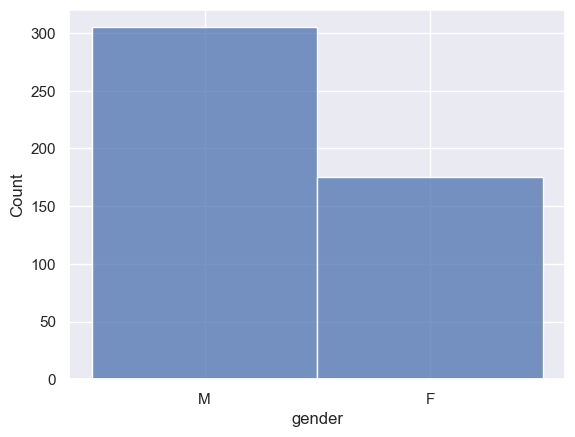

In [7]:
sns.histplot(original_data["gender"])

Let's find out how the results ('Class') are distributed

<Axes: xlabel='Class', ylabel='Count'>

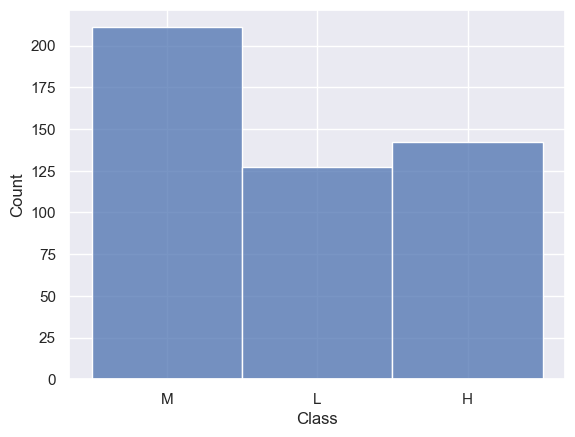

In [8]:
# Check class distribution
sns.histplot(original_data['Class'])

#### **Synthetic Data Generation**

Now we'll prepare for SDG and split up the original data into 30/70 test/train splits. If the splits were created earlier already, we will load the existing splits.

In [9]:
# Set the path to the original data
original_data_path = "../data/original_data/1_university_of_jordan/"
train_file = os.path.join(original_data_path, "train_data.csv")
test_file = os.path.join(original_data_path, "test_data.csv")

# Check if the train and test data files already exist
if os.path.isfile(train_file) and os.path.isfile(test_file):
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    print("Train and test data loaded.")
else:
    # Split the data into train and test sets
    train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
    train_data.to_csv(train_file, index=False)
    test_data.to_csv(test_file, index=False)
    print("Train and test data saved.")

Train and test data loaded.


First check whether the synthetic datasets were already generated. If not, use the train split to train the SDG models and sample as many entries as the train dataset contains. 

In [10]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

synth_path = "../data/synthetic_data/1_university_of_jordan/"
csv_files = [file for file in os.listdir(synth_path) if file.endswith(".csv")]
dataset_name = '1_university_of_jordan'

# Number of samples to generate: same as the number of samples in the train data
n = len(train_data)

if len(csv_files) == 0:

    # Set the path to the train split
    data_path = original_data_path + "train_data.csv"
    # Set up arguments to pass to the R script
    arguments = [data_path, str(n), dataset_name]

    print("Fit models and create synthetic data:")
    print("synthpop...")
    result = subprocess.run(['Rscript', '../src/generation/synthpop.R',   *arguments], capture_output=True, text=True)

    print("\nDataSynthesizer...")
    ds_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)

    print("\nSDV:")
    sdv_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)

    print("\nSynthetic data generated.")
else:
    print("Synthetic data already exists.")

Synthetic data already exists.


Load the synthetic datasets and encode all categorical columns of both original (train+test) data and synthetic data using label encoding to prepare for utility evaluation.

In [11]:
# Load synthetic data
synthpop = pd.read_csv(synth_path + "synthpop.csv")
ds = pd.read_csv(synth_path + "ds.csv")
tvae = pd.read_csv(synth_path + "tvae.csv")
gaussian_copula = pd.read_csv(synth_path + "gaussian_copula.csv")
copula_gan = pd.read_csv(synth_path + "copula_gan.csv")
ctgan = pd.read_csv(synth_path + "ctgan.csv")

# Encode categorical columns as integers
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le

Check data...

In [12]:
synthpop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   gender                    288 non-null    int64
 1   NationalITy               288 non-null    int64
 2   PlaceofBirth              288 non-null    int64
 3   StageID                   288 non-null    int64
 4   GradeID                   288 non-null    int64
 5   SectionID                 288 non-null    int64
 6   Topic                     288 non-null    int64
 7   Semester                  288 non-null    int64
 8   Relation                  288 non-null    int64
 9   raisedhands               288 non-null    int64
 10  VisITedResources          288 non-null    int64
 11  AnnouncementsView         288 non-null    int64
 12  Discussion                288 non-null    int64
 13  ParentAnsweringSurvey     288 non-null    int64
 14  ParentschoolSatisfaction  288 non-null    

#### **Utility**

In order to evaluate the utility of the synthetic datasets, the following steps will executed three times, each time with a different ML model.

1. Two models are trained: one using the original train data and the other one using synthetic data.
2. The two different models will predict the target column using the test split.
3. The difference in performance between the two models will be reported via accuracy diff, f1-score diff, and auc-roc diff

In [13]:
# Set target column
target_col = 'Class'
synth_datasets = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]

Run **random forest classifier** for utility evaluation.

In [14]:
rf_results = {}
rf_df = pd.read_csv("../data/results/tables/rf.csv")
rows = []

# Check if random forest results for the dataset already exist
if (rf_df["Dataset"] == 1).any():
    print("Random Forest result for '1_university_of_jordan' already exists")
else:
    # Run utility evaluation using random forest for each synthetic dataset and store results
    for i, synth_dataset in enumerate(synth_datasets):
        rf_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "random_forest")
        
        acc_diff = rf_results[model_names[i]]["acc_diff"]
        f1_diff = rf_results[model_names[i]]["f1_diff"]
        roc_auc_diff = rf_results[model_names[i]]["roc_auc_diff"]

        rows.append([1,model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rf_df = pd.DataFrame(rows, columns=["Dataset", "Model", "Accuracy Difference", "F1 Score Difference", "ROC AUC Difference"])
    rf_df.to_csv("../data/results/tables/rf.csv", index=False)

rf_df.head()

Random Forest result for '1_university_of_jordan' already exists


,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
0,1,synthpop,0.11,0.10,0.06
1,1,ds,0.46,0.44,0.46
2,1,tvae,0.23,0.32,0.07
3,1,gaussian_copula,0.34,0.39,0.32
4,1,copula_gan,0.37,0.44,0.32


Run **logistic regression** for utility evaluation.

In [15]:
lr_results = {}
rows = []
lr_df = pd.read_csv("../data/results/tables/lr.csv")

if (lr_df["Dataset"] == 1).any():
    print("Logistic regression result for '1_university_of_jordan' already exists")
else:
    # Run utility evaluation using logistic regression for each model and store results
    for i, synth_dataset in enumerate(synth_datasets):
        lr_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "logistic_regression")

        acc_diff = lr_results[model_names[i]]["acc_diff"]
        f1_diff = lr_results[model_names[i]]["f1_diff"]
        roc_auc_diff = lr_results[model_names[i]]["roc_auc_diff"]

        rows.append([1,model_names[i], acc_diff, f1_diff, roc_auc_diff])

    lr_df = pd.DataFrame(rows, columns=["Dataset", "Model", "Accuracy Difference", "F1 Score Difference", "ROC AUC Difference"])
    lr_df.to_csv("../data/results/tables/lr.csv", index=False)
    
lr_df.head()

Logistic regression result for '1_university_of_jordan' already exists


,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
0,1,synthpop,0.08,0.09,0.03
1,1,ds,0.38,0.38,0.46
2,1,tvae,0.12,0.21,0.16
3,1,gaussian_copula,0.26,0.32,0.27
4,1,copula_gan,0.23,0.29,0.31


Run **multilayer perceptron (MLP)** for utility evaluation.

In [16]:
mlp_results = {}
rows = []
mlp_df = pd.read_csv("../data/results/tables/mlp.csv")

if (mlp_df["Dataset"] == 1).any():
    print("MLP result for '1_university_of_jordan' already exists")
else:
    # Run utility evaluation using MLP for each model and store results
    for i, synth_dataset in enumerate(synth_datasets):
        mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "multilayer_perceptron")

        acc_diff = mlp_results[model_names[i]]["acc_diff"]
        f1_diff = mlp_results[model_names[i]]["f1_diff"]
        roc_auc_diff = mlp_results[model_names[i]]["roc_auc_diff"]

        rows.append([1,model_names[i], acc_diff, f1_diff, roc_auc_diff])

    mlp_df = pd.DataFrame(rows, columns=["Dataset", "Model", "Accuracy Difference", "F1 Score Difference", "ROC AUC Difference"])
    mlp_df.to_csv("../data/results/tables/mlp.csv", index=False)
    
mlp_df.head()

MLP result for '1_university_of_jordan' already exists


,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
0,1,synthpop,0.09,0.09,0.04
1,1,ds,0.46,0.43,0.44
2,1,tvae,0.16,0.23,0.15
3,1,gaussian_copula,0.23,0.24,0.20
4,1,copula_gan,0.16,0.17,0.22


#### **Resemblance**

The resemblance dimension includes mutliple distance metrics to measure the similarity of the synthetic and real data: **Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance**

- **Difference in pairwise correlation** is used to measure how well feature-interactions are preserved within synthetic data. First the pairwise correlation matrices for each real and synthetic data is computed. Pearson correlation coefficient is used for continuous features ( [-1,1] range) and the Theil uncer-
tainty coefficient ([0,1] range) for categorical features
    - lower (difference) values are better
- **JSD** is a method for measuring similarity between two probability distributions. It is based on Kullback-Leibler divergence, but has several benefits like being symmetric and having finite values. Values are bounded between 0 and 1, where values close to 0 indicate high similarity and values close to 1 indicate almost no similarity between the distributions.
    - lower values are better
- **WD** is used to compare the distributions of two continuous/mixed variables, where one variable is derived from the other → how well the synthetic data emulates the distribution of the
individual variables
    - lower values are better

**Difference in pairwise correlation:**

In [17]:
rows = []
corr_diff_df = pd.read_csv("../data/results/tables/corr_diff.csv")

if (corr_diff_df["Dataset"] == 1).any():
    print("Entry for '1_university_of_jordan' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = pairwise_correlation_diff(train_data, synth_dataset)
        rows.append([1,model_names[i], result])

    corr_diff_df = pd.DataFrame(rows, columns=["Dataset", "Model", "Pairwise Corr Diff"])
    corr_diff_df.to_csv("../data/results/tables/corr_diff.csv", index=False)
    
corr_diff_df.head()

Entry for '1_university_of_jordan' already exists


,Dataset,Model,Pairwise Corr Diff
0,1,synthpop,0.058116
1,1,ds,0.154599
2,1,tvae,0.149854
3,1,gaussian_copula,0.116951
4,1,copula_gan,0.156744


**Jensen-Shannon Divergence**

In [18]:
rows = []
jsd_df = pd.read_csv("../data/results/tables/jsd.csv")

if (jsd_df["Dataset"] == 1).any():
    print("Entry for '1_university_of_jordan' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = jsd(train_data, synth_dataset)
        rows.append([1,model_names[i], result])

    jsd_df = pd.DataFrame(rows, columns=["Dataset", "Model", "JSD Diff"])
    jsd_df.to_csv("../data/results/tables/jsd.csv", index=False)
    
jsd_df.head()

Entry for '1_university_of_jordan' already exists


,Dataset,Model,JSD Diff
0,1,synthpop,0.029851
1,1,ds,0.089329
2,1,tvae,0.152463
3,1,gaussian_copula,0.050700
4,1,copula_gan,0.045132


**Wasserstein Distance**

In [19]:
wd_results = {}
rows = []
wd_df = pd.read_csv("../data/results/tables/wd.csv")

if (wd_df["Dataset"] == 1).any():
    print("Entry for '1_university_of_jordan' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        wd_results[model_names[i]] = wd(train_data, synth_dataset)
        rows.append([1,model_names[i], wd_results[model_names[i]]])

    wd_df = pd.DataFrame(rows, columns=["Dataset", "Model", "WD Diff"])
    wd_df.to_csv("../data/results/tables/wd.csv", index=False)
    
wd_df.head()

Entry for '1_university_of_jordan' already exists


,Dataset,Model,WD Diff
0,1,synthpop,0.020604
1,1,ds,0.054549
2,1,tvae,0.119978
3,1,gaussian_copula,0.015245
4,1,copula_gan,0.027005


#### **Privacy**

To assess the privacy aspect of the synthetic data the metrics **Distance to closest Record (DCR)**, **Nearest Neighbour Difference Ratio (NNDR)** and **Membership Inference Attack (MIA)** will be used. 

- In **DCR** the euclidean distance between
each record in original and synthetic dataset is computed. DCR is the minimum distance between a synthetic record and a original record. 
    - A value of zero indicates that the synthetic record is an identical copy of the original one -> leak of real information, higher values indicate more privacy

- **NNDR** is ratio between nearest and second nearest real neighbour to any corresponding synthetic record (NNDR(s) = d1/d2) and is within [0,1]
    - higher values indicate better privacy

- **MIA** is used to assess the disclosure risk by assuming that an attacker has access to all the records of the synthetic data and to a random subset of the original data. Using a real record the attacker then tries to find the closest record in the synthetic dataset. If there is any distance below some threshold, the attacker can assume that the corresponding real record was used to generate the synthetic data.
    - For strong privacy preservation both accuracy and precision should be below 0.5 for all thresholds 

**Distance to closest record (DCR)**

In [20]:
rows = []
dcr_df = pd.read_csv("../data/results/tables/dcr.csv")

if (dcr_df["Dataset"] == 1).any():
    print("Entry for '1_university_of_jordan' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_hist=True)
        result_within_real = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Original", save_hist=False)
        result_within_synth = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Synthetic", save_hist=False)
        rows.append([1,model_names[i], result, result_within_real, result_within_synth])

    dcr_df = pd.DataFrame(rows, columns=["Dataset", "Model", "DCR 5th Percentile", "DCR 5th Percentile (within Real)", "DCR 5th Percentile (within Synthetic)"])
    dcr_df.to_csv("../data/results/tables/dcr.csv", index=False)

dcr_df.head()   

Entry for '1_university_of_jordan' already exists


,Dataset,Model,DCR 5th Percentile,DCR 5th Percentile (within Real),DCR 5th Percentile (within Synthetic)
0,1,synthpop,6.220,5.568,6.481
1,1,ds,12.153,5.568,11.314
2,1,tvae,7.507,5.568,5.385
3,1,gaussian_copula,8.449,5.568,7.937
4,1,copula_gan,12.016,5.568,11.563


**Nearest Neighbor distance ratio (NNDR)**

In [21]:
rows = []
nndr_df = pd.read_csv("../data/results/tables/nndr.csv")

if (nndr_df["Dataset"] == 1).any():
    print("Entry for '1_university_of_jordan' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = nndr(train_data, synth_dataset)
        result_within_real = nndr(train_data, synth_dataset, within="Original")
        result_within_synth = nndr(train_data, synth_dataset, within="Synthetic")
        rows.append([1,model_names[i], result, result_within_real, result_within_synth])

    nndr_df = pd.DataFrame(rows, columns=["Dataset", "Model", "NNDR 5th percentile", "NNDR 5th percentile (within Real)", "NNDR 5th percentile (within Synthetic)"])
    nndr_df.to_csv("../data/results/tables/nndr.csv", index=False)

nndr_df.head()  

Entry for '1_university_of_jordan' already exists


,Dataset,Model,NNDR 5th percentile,NNDR 5th percentile (within Real),NNDR 5th percentile (within Synthetic)
0,1,synthpop,0.439,0.493,0.449
1,1,ds,0.560,0.493,0.569
2,1,tvae,0.564,0.493,0.522
3,1,gaussian_copula,0.557,0.493,0.499
4,1,copula_gan,0.572,0.493,0.614


**Membership Inference Attack (MIA)**

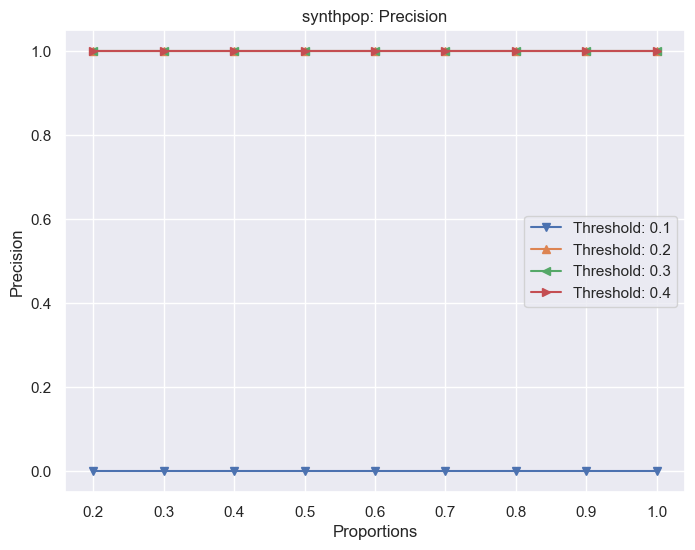

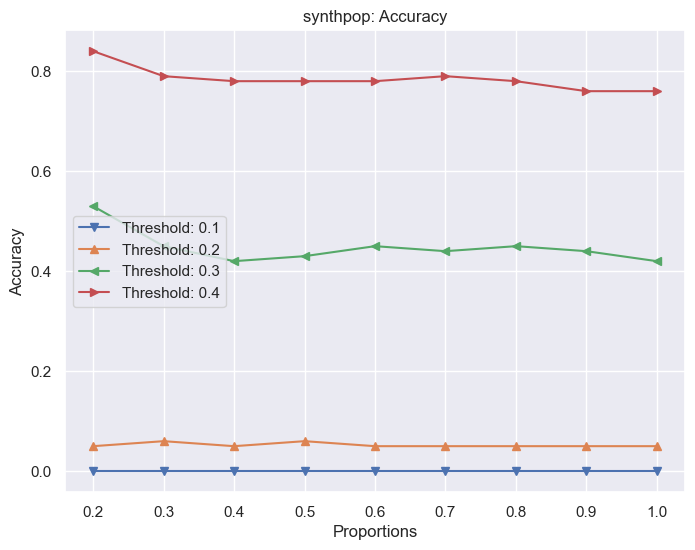

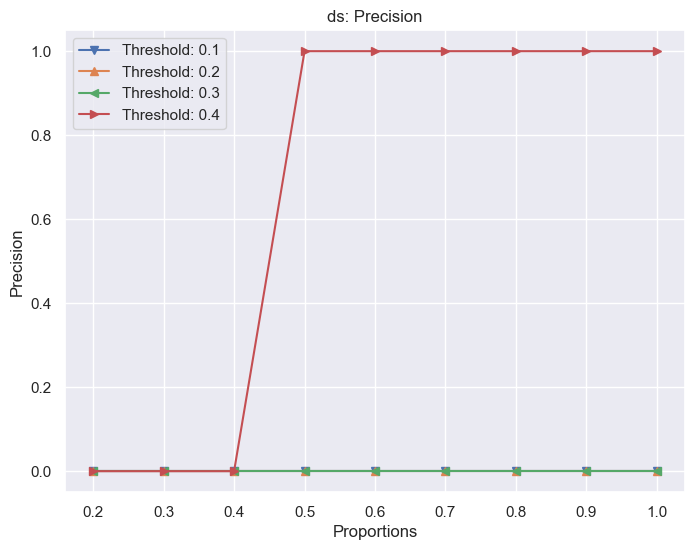

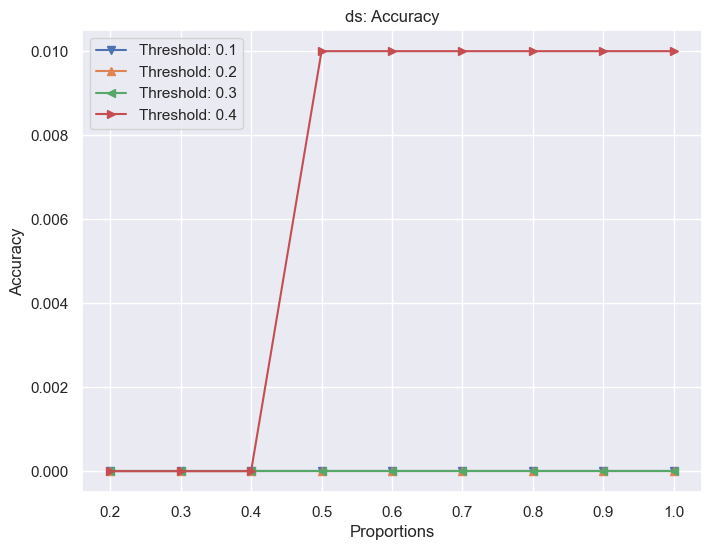

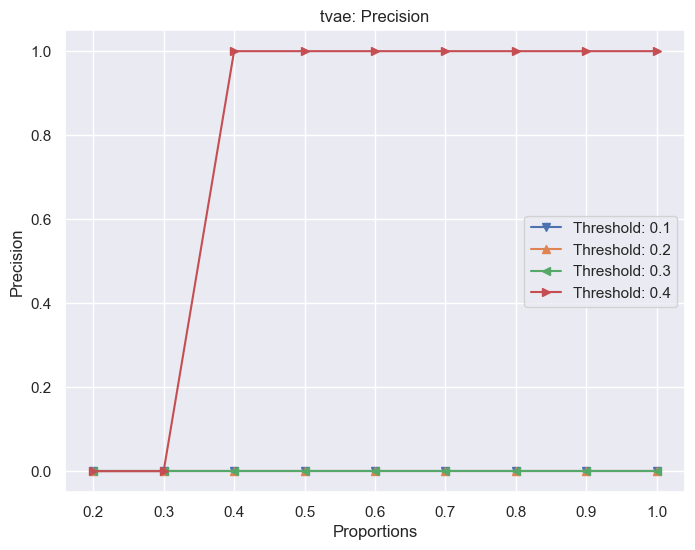

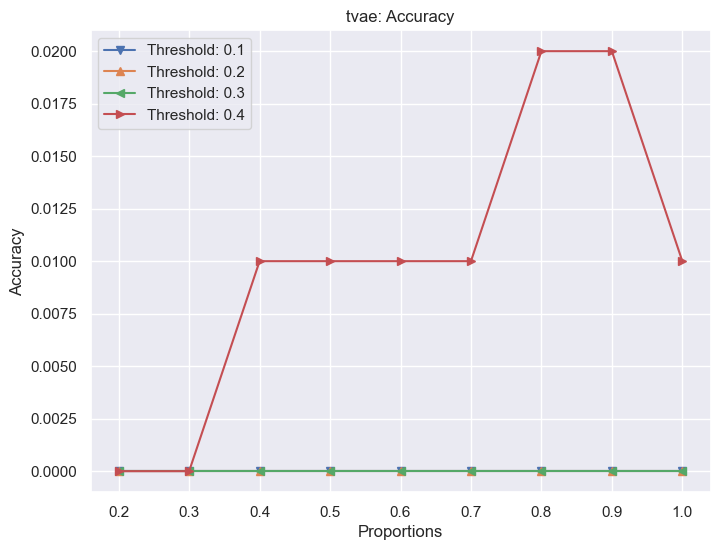

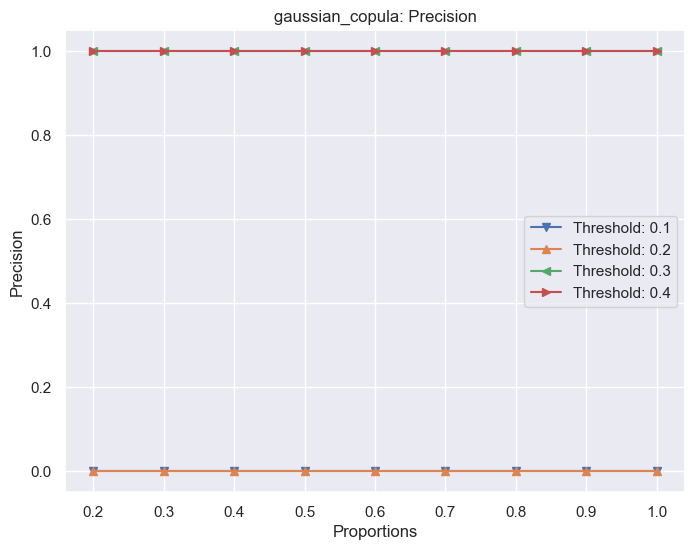

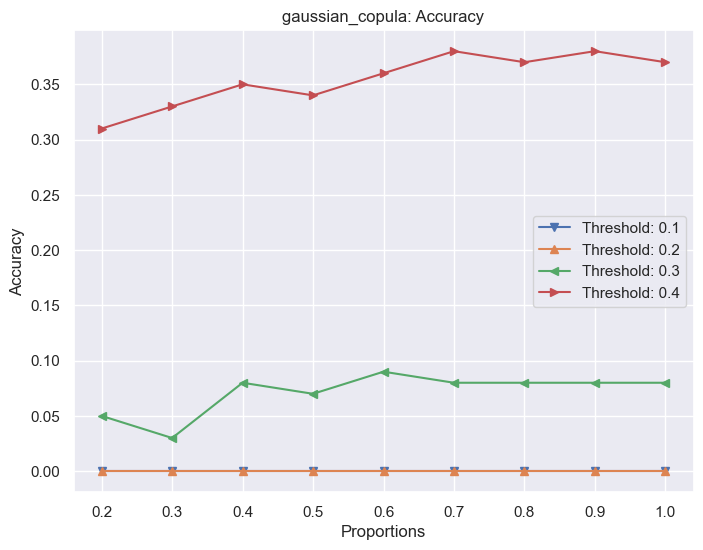

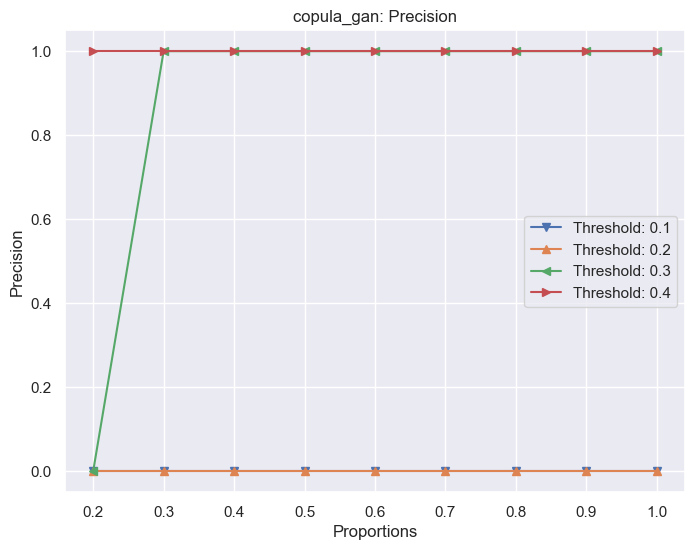

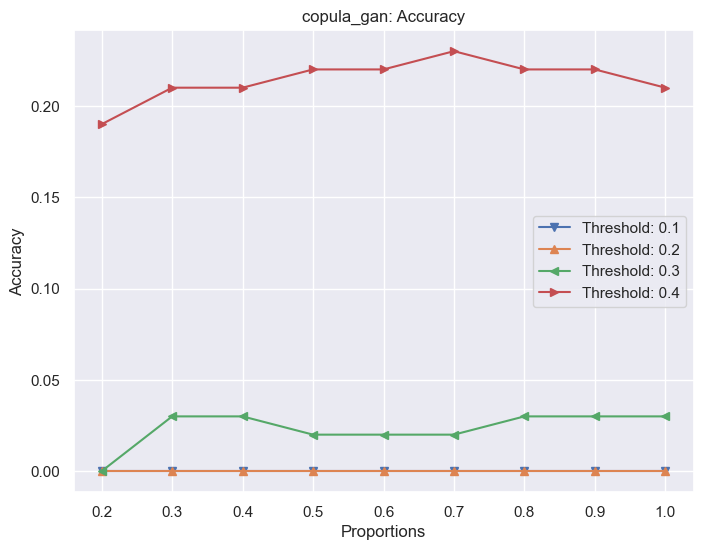

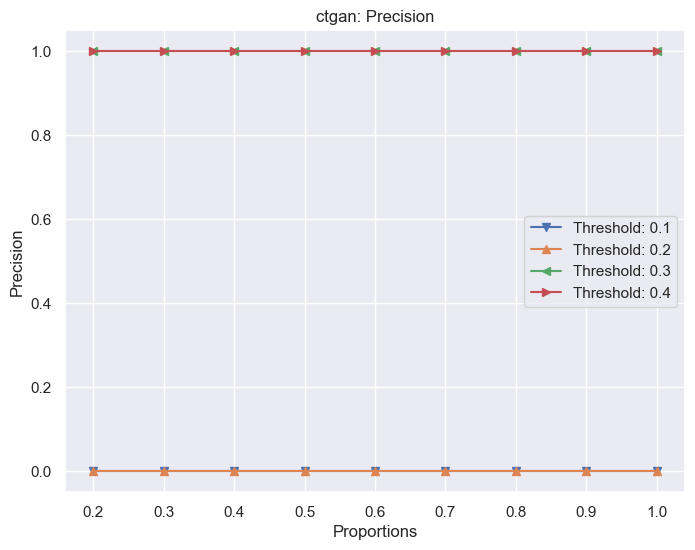

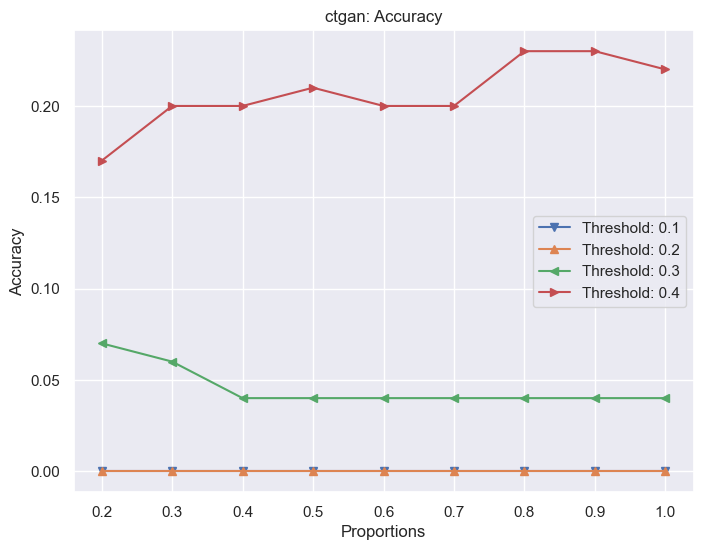

In [22]:
import glob
mia_results = {}
mia_path = "../data/results/plots/mia/1_university_of_jordan/"
mia_files = glob.glob(os.path.join(mia_path, "*.png"))
if (mia_files):
    print("MIA results for 1_university_of_jordan already exist.")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        mia_results[model_names[i]] = mia(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_plts=True)